In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from scipy.integrate import odeint
import matplotlib.animation as animation

# Simple Model

Let's start with a very simple model consisting of three boxes: land, upper ocean, and deep ocean.  The land is assumed to have near-zero heat capacity.  The ocean is a two-box model with mixed layer (small heat capacity) and deep ocean (very large heat capacity).  Energy can be transported from land -> mixed layer and from mixed layer -> land, but not from land -> deep ocean.

### Forcing

Forcing: take 2xCO2 forcing (assumed to be 3.72 W/m2) and partition such that [forcing_fraction_land] is over land. Can choose between 
* "abrupt" (abruptly double CO2)
* "1pctCO2" (increase at 1%/year)
* ramp" (increase at 1%/year to doubling, then hold constant)

In [3]:
def PartitionForcing(forcing_fraction_land = None,typ="abrupt",landfrac=0.29):
    """
    Arguments:
    forcing_fraction_land: amount of forcing over land (default = landfrac for well-mixed)
    typ: type of forcing (abrupt, 1%CO2/year, ramp)
    landfrac: fraction of Earth's surface covered by land
    """
    if forcing_fraction_land is None:
        forcing_fraction_land = landfrac
    oceanfrac = 1.-landfrac
    ### Forcing type ###
    if typ == "abrupt":
        F = lambda t: 3.726 #Double CO2 abruptly; fix for all times
    elif typ == "1pctCO2":
        F = lambda t: 5.35*np.log(1.01)*t #Increase CO2 continuously at 1%/year
    elif typ == "ramp":
        F = lambda t: 5.35*np.log(1.01)*t if t<= 70 else 3.726 #Increase CO2 to doubling; then hold constant
    else:
        print "typ must be one of [abrupt,1pctCO2,ramp]"
        raise TypeError
    FL = lambda t: F(t)*forcing_fraction_land/landfrac
    FO = lambda t: F(t)*(1.-forcing_fraction_land)/oceanfrac
    return FL, FO

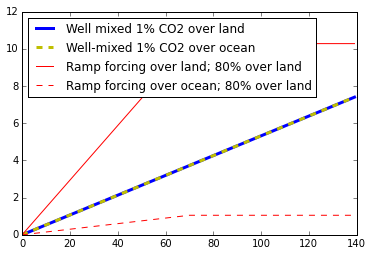

In [4]:
FL,FO=PartitionForcing(.29,typ="1pctCO2")
T = np.arange(140)
plt.plot(T,[FL(t) for t in T],"b",lw=3,label="Well mixed 1% CO2 over land")
plt.plot(T,[FO(t) for t in T],"y--",lw=3,label = "Well-mixed 1% CO2 over ocean")
FL,FO = PartitionForcing(.8,typ="ramp")
plt.plot(T,[FL(t) for t in T],"r",label="Ramp forcing over land; 80% over land")
plt.plot(T,[FO(t) for t in T],"r--",label="Ramp forcing over ocean; 80% over land")
plt.legend(loc=0)

In [5]:
def vectorfield(w,t,p):
    """
    Arguments:
    w :  vector of the state variables:
        w = [T_land, T_mixedlayer, T_deep]
    t :  time
    p :  vector of the parameters:
        p = [FL,FO, lambda_l, lambda_o, alpha_l, alpha_o, gamma, landfrac]
    """
    CL = 0.01
    CML = 12.
    CDO = 244.
    FL, FO, lambda_l, lambda_o, alpha_l, alpha_o,gamma, landfrac = p
    T_land, T_mixedlayer, T_deep = w
    f = [1/CL*(FL(t) - lambda_l*T_land + alpha_o/landfrac*T_mixedlayer-alpha_l/landfrac*T_land),\
        1/CML*(FO(t)-lambda_o*T_mixedlayer-alpha_o/(1-landfrac)*T_mixedlayer + alpha_l/(1-landfrac)*T_land-gamma*(T_mixedlayer-T_deep)),\
        1/CDO*gamma*(T_mixedlayer - T_deep)]

    return f
    

In [6]:
def SolveDiffEq(params,show=True,cmap=cm.jet):
    """
    Arguments:
    p :  vector of the parameters:
        p = [FL,FO, lambda_l, lambda_o, alpha_l, alpha_o, gamma, landfrac]
    """
    
    #Initial conditions
    T_land = 0
    T_mixedlayer = 0
    T_deep = 0


    # ODE solver parameters
    abserr = 1.0e-8
    relerr = 1.0e-6
    stoptime = 500.0
    numpoints = 500

    # Create the time samples for the output of the ODE solver.
    # I use a large number of points, only because I want to make
    # a plot of the solution that looks nice.
    t = [stoptime * float(i) / (numpoints - 1) for i in range(numpoints)]


    p = params
    w0 = [ T_land, T_mixedlayer, T_deep]
    
    wsol = odeint(vectorfield, w0, t, args=(p,),atol=abserr, rtol=relerr)
    if show:
        plt.plot(t,wsol[:,0],color=cmap(.33),label="T_land",lw=3)
        plt.plot(t,wsol[:,1],color=cmap(.66),label="T_mixedlayer",lw=3)
        plt.plot(t,wsol[:,2],color=cmap(.99),label="T_deepocean",lw=3)
        plt.legend(loc=0)
    return wsol

## Parameters

The simple model is governed by the following parameters:
* landfrac = percentage of the surface covered by land
* FL = forcing over land
* FO = forcing over ocean
* lambda_l = response over land
* lambda_o = response over ocean
* alpha_l = horizontal energy transport from land to mixed layer
* alpha_o = horizontal energy transport from mixed layer to land
* gamma = rate of vertical advection into the deep ocean

## SET PARAMETERS HERE

In [7]:
landfrac = 0.29
typ="ramp" #Determines forcing type
lambda_l = 3.2
lambda_o = 3.2
alpha_l = 1.62
alpha_o = 2.39
gamma = 2.0

Plug in the land fraction and the forcing type to get well-mixed forcing, land only forcing

In [8]:
FL_mixed, FO_mixed = PartitionForcing(forcing_fraction_land = 0.29,typ=typ,landfrac = landfrac)
FL_land, FO_land = PartitionForcing(forcing_fraction_land = 1.,typ=typ,landfrac = landfrac)

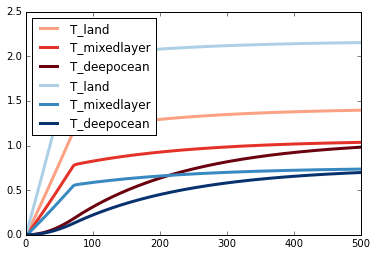

In [9]:

params_mixed = [FL_mixed,FO_mixed,lambda_l, lambda_o, alpha_l, alpha_o, gamma, landfrac]
mixed_solution = SolveDiffEq(params_mixed,cmap=cm.Reds)
params_land = [FL_land,FO_land,lambda_l, lambda_o, alpha_l, alpha_o, gamma, landfrac]
land_solution = SolveDiffEq(params_land,cmap=cm.Blues)

In [10]:
def globalmeanT(wsol,landfrac=0.29):
    return landfrac*wsol[:,0]+(1-landfrac)*wsol[:,1]

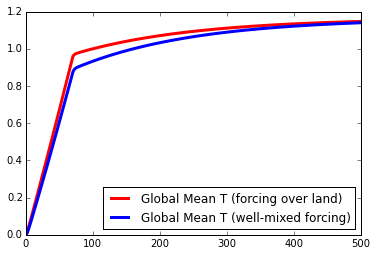

In [11]:
T_avg_land = globalmeanT(land_solution,landfrac = 0.29)
T_avg_mixed = globalmeanT(mixed_solution,landfrac=0.29)
plt.plot(T_avg_land,c="r",lw=3,label="Global Mean T (forcing over land)")
plt.plot(T_avg_mixed,c="b",lw=3,label="Global Mean T (well-mixed forcing)")
plt.legend(loc=0)



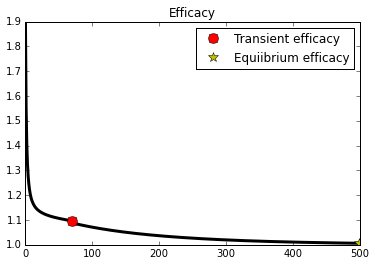

In [12]:
plt.plot(T_avg_land[1:]/T_avg_mixed[1:],c="k",lw=3)
plt.title("Efficacy")
plt.plot([70],[T_avg_land[70]/T_avg_mixed[70]],"ro",markersize=10,label="Transient efficacy")
plt.plot([499],[T_avg_land[499]/T_avg_mixed[499]],"y*",markersize=10,label="Equiibrium efficacy")
plt.xlim(0,501)
plt.legend(loc=0,numpoints=1)

In [13]:
def get_efficacies(params):
    lambda_l, lambda_o, alpha_l, alpha_o, gamma, landfrac = params
    FL_mixed, FO_mixed = PartitionForcing(forcing_fraction_land = landfrac,typ="ramp",landfrac = landfrac)
    FL_land, FO_land = PartitionForcing(forcing_fraction_land = 1.,typ="ramp",landfrac = landfrac)
    params_mixed = [FL_mixed,FO_mixed,lambda_l, lambda_o, alpha_l, alpha_o, gamma, landfrac]
    mixed_solution = SolveDiffEq(params_mixed,show=False)
    params_land = [FL_land,FO_land,lambda_l, lambda_o, alpha_l, alpha_o, gamma, landfrac]
    land_solution = SolveDiffEq(params_land,show=False)
    T_avg_land = globalmeanT(land_solution,landfrac = landfrac)
    T_avg_mixed = globalmeanT(mixed_solution,landfrac=landfrac)
    TCR_efficacy = T_avg_land[70]/T_avg_mixed[70]
    ECS_efficacy = T_avg_land[-1]/T_avg_mixed[-1]
    return TCR_efficacy, ECS_efficacy
    

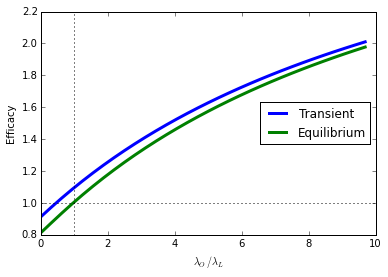

In [14]:
lambda_l = 3.2
LAMO=np.arange(0.,lambda_l*10,1)
alpha_l = 1.62
alpha_o = 2.39
gamma = 2.0
landfrac = .29
Te=[]
Ee=[]
for lambda_o in LAMO:
    teff,eeff=get_efficacies([lambda_l, lambda_o, alpha_l, alpha_o, gamma, landfrac ])
    Te+=[teff]
    Ee+=[eeff]

plt.plot(LAMO/lambda_l,Te,c="b",lw=3,label="Transient")
plt.plot(LAMO/lambda_l,Ee,c="g",lw=3,label="Equilibrium")
plt.axvline(1.,c='k',ls=":")
plt.axhline(1.,c='k',ls=":")
plt.xlabel(r"$\lambda_O/\lambda_L$")
plt.ylabel("Efficacy")
plt.legend(loc=0)

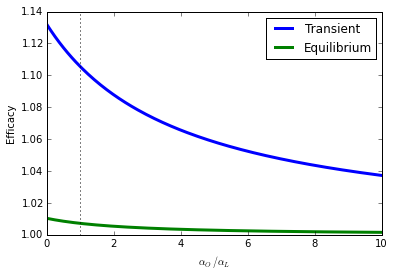

In [15]:
lambda_l = 3.2
lambda_o = 3.2
alpha_l = 1.62
AO = np.arange(0,alpha_l*10,.1)
gamma = 2.0
landfrac = .29
Te=[]
Ee=[]
for alpha_o in AO:
    teff,eeff=get_efficacies([lambda_l, lambda_o, alpha_l, alpha_o, gamma, landfrac ])
    Te+=[teff]
    Ee+=[eeff]

plt.plot(AO/alpha_l,Te,c="b",lw=3,label="Transient")
plt.plot(AO/alpha_l,Ee,c="g",lw=3,label="Equilibrium")
plt.axvline(1.,c='k',ls=":")
plt.axhline(1.,c='k',ls=":")
plt.xlabel(r"$\alpha_O/\alpha_L$")
plt.ylabel("Efficacy")
plt.legend(loc=0)

In [94]:
Ttest = np.zeros((len(LAMO),len(AO)))
Etest = np.zeros((len(LAMO),len(AO)))
for i in range(len(LAMO)):
    for j in range(len(AO)):
        alpha_o = AO[j]
        lambda_o = LAMO[i]
        teff,eeff=get_efficacies([lambda_l, lambda_o, alpha_l, alpha_o, gamma, landfrac ])
        Ttest[i,j]=teff
        Etest[i,j]=eeff
        

In [96]:
x,y = np.meshgrid(AO,LAMO)
x.shape

(32, 163)

<matplotlib.colorbar.Colorbar instance at 0x118af85a8>

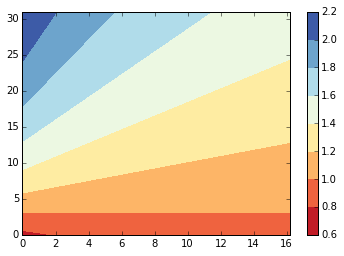

In [101]:
plt.contourf(x,y,Etest,cmap=cm.RdYlBu)
plt.colorbar()